In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (
    StandardScaler, MinMaxScaler, OneHotEncoder, PowerTransformer
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report, confusion_matrix
)

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# 1. Load the cleaned dataset used in EDA
df = pd.read_csv("cleaned_dataset_EDA.csv")
print(df.shape)
df.head()


(83074, 21)


,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [2]:
# 2. Remove extreme outliers (same idea as Part 5)
min_duration = 30 * 1000          # 30 seconds
max_duration = 20 * 60 * 1000     # 20 minutes

before = df.shape[0]
df = df[(df["duration_ms"] >= min_duration) & (df["duration_ms"] <= max_duration)]
print(f"Removed {before - df.shape[0]} rows based on duration bounds")

# 3. Create popularity tiers of width 20: 0–20, 20–40, ..., 80–100
bins = list(range(0, 101, 20))
labels = [f"{i}-{i+20}" for i in range(0, 100, 20)]

df["popularity_tier"] = pd.cut(
    df["popularity"],
    bins=bins,
    labels=labels,
    right=False
)

before = df.shape[0]
df = df.dropna(subset=["popularity_tier"])
print(f"Dropped {before - df.shape[0]} rows with undefined popularity tier")

y = df["popularity_tier"].astype(str)
print("Class distribution:")
print(y.value_counts().sort_index())




Removed 87 rows based on duration bounds
Dropped 1 rows with undefined popularity tier
Class distribution:
popularity_tier
0-20      18102
20-40     30053
40-60     25594
60-80      8673
80-100      564
Name: count, dtype: int64


In [3]:
# 4. Interaction features motivated by EDA (loudness behaves differently by genre)
df["is_acoustic"]   = (df["track_genre"] == "acoustic").astype(int)
df["is_heavymetal"] = (df["track_genre"] == "heavy-metal").astype(int)
df["is_dance"]      = (df["track_genre"] == "dance").astype(int)

df["loudness_x_acoustic"]   = df["loudness"] * df["is_acoustic"]
df["loudness_x_heavymetal"] = df["loudness"] * df["is_heavymetal"]
df["loudness_x_dance"]      = df["loudness"] * df["is_dance"]

# 5. Feature sets
numeric_features = [
    "danceability", "energy", "loudness", "speechiness", "acousticness",
    "instrumentalness", "liveness", "valence", "tempo", "duration_ms",
    "loudness_x_acoustic", "loudness_x_heavymetal", "loudness_x_dance",
]

categorical_features = ["track_genre", "key", "time_signature"]

X = df[numeric_features + categorical_features].copy()
print("Feature matrix shape:", X.shape)


Feature matrix shape: (82986, 16)


In [4]:
# Split numeric features into groups based on distribution shape
skewed_features = ["acousticness", "instrumentalness", "speechiness", "liveness"]
less_skewed_features = ["danceability", "energy", "valence"]
unbounded_features = [
    "loudness", "tempo", "duration_ms",
    "loudness_x_acoustic", "loudness_x_heavymetal", "loudness_x_dance"
]

numeric_transformer = ColumnTransformer(
    transformers=[
        ("skewed_power", PowerTransformer(method="yeo-johnson"), skewed_features),
        ("bounded_minmax", MinMaxScaler(), less_skewed_features),
        ("unbounded_standard", StandardScaler(), unbounded_features),
    ],
    remainder="passthrough",
)

categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_transformer, numeric_features),
        ("categorical", categorical_transformer, categorical_features),
    ]
)

# Train–test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (66388, 16) Test: (16598, 16)


In [5]:
# Logistic Regression model
log_reg = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", LogisticRegression(
            C=1.0,
            penalty="l2",
            max_iter=1000,
            class_weight="balanced",
            multi_class="auto",
            random_state=42,
        )),
    ]
)

# SVM with RBF kernel
svm_rbf = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", SVC(
            kernel="rbf",
            C=10.0,
            gamma="scale",
            class_weight="balanced",
            random_state=42,
        )),
    ]
)

print("Fitting Logistic Regression...")
log_reg.fit(X_train, y_train)

print("Fitting SVM (RBF)...")
svm_rbf.fit(X_train, y_train)

# Predictions
y_pred_log = log_reg.predict(X_test)
y_pred_svm = svm_rbf.predict(X_test)


Fitting Logistic Regression...


/Users/zoyamalik/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Fitting SVM (RBF)...


In [6]:
def compute_metrics(y_true, y_pred, model_name):
    return {
        "Model": model_name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Macro F1": f1_score(y_true, y_pred, average="macro"),
        "Weighted F1": f1_score(y_true, y_pred, average="weighted"),
        "Macro Precision": precision_score(y_true, y_pred, average="macro"),
        "Macro Recall": recall_score(y_true, y_pred, average="macro"),
    }

log_metrics = compute_metrics(y_test, y_pred_log, "Logistic Regression")
svm_metrics = compute_metrics(y_test, y_pred_svm, "SVM (RBF Kernel)")

metrics_df = pd.DataFrame([log_metrics, svm_metrics])
metrics_df


,Model,Accuracy,Macro F1,Weighted F1,Macro Precision,Macro Recall
0,Logistic Regression,0.565550,0.470077,0.593634,0.480279,0.588532
1,SVM (RBF Kernel),0.617123,0.514809,0.628890,0.508057,0.551796


<Figure size 1000x600 with 0 Axes>

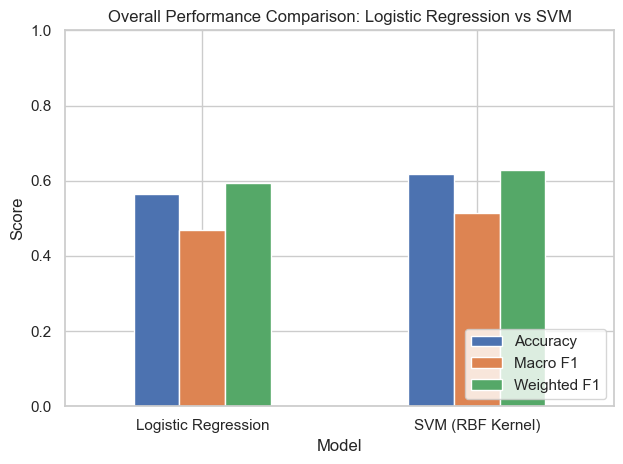

In [7]:
plt.figure(figsize=(10, 6))
metrics_df.set_index("Model")[["Accuracy", "Macro F1", "Weighted F1"]].plot(kind="bar")
plt.title("Overall Performance Comparison: Logistic Regression vs SVM")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


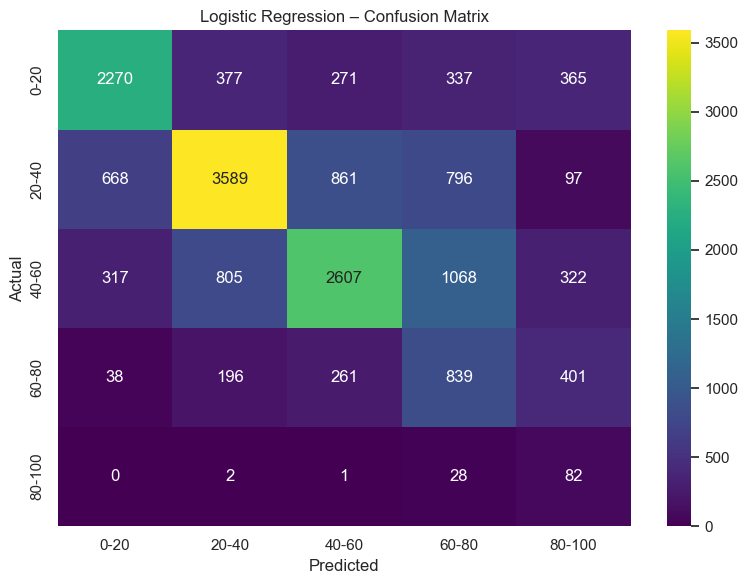

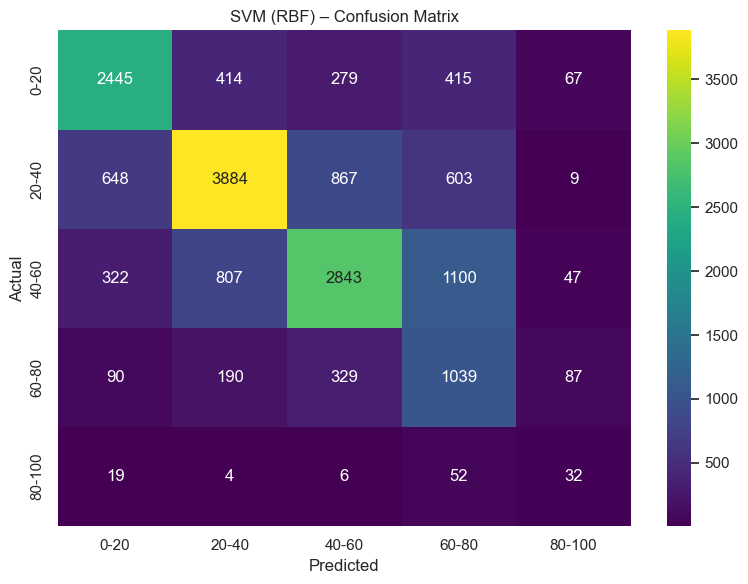

In [8]:
def plot_conf_matrix(y_true, y_pred, title):
    labels = sorted(y_true.unique())
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="viridis",
        xticklabels=labels,
        yticklabels=labels,
    )
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

plot_conf_matrix(y_test, y_pred_log, "Logistic Regression – Confusion Matrix")
plot_conf_matrix(y_test, y_pred_svm, "SVM (RBF) – Confusion Matrix")


In [9]:
def class_f1_scores(y_true, y_pred, model_name):
    report = classification_report(y_true, y_pred, output_dict=True)
    class_labels = sorted(y_true.unique())

    scores = {
        "Class": class_labels,
        f"{model_name} F1": [report[c]["f1-score"] for c in class_labels],
    }
    return pd.DataFrame(scores)

log_f1 = class_f1_scores(y_test, y_pred_log, "LogReg")
svm_f1 = class_f1_scores(y_test, y_pred_svm, "SVM")

f1_compare = log_f1.merge(svm_f1, on="Class")
f1_compare


,Class,LogReg F1,SVM F1
0,0-20,0.656734,0.684490
1,20-40,0.653734,0.686826
2,40-60,0.571711,0.602139
3,60-80,0.349365,0.420307
4,80-100,0.118841,0.180282


## 6. Model Evaluation and Interpretation

In this section, we evaluate the performance of the two classification models Logistic Regression and an SVM with an RBF kernel on the held-out test set. Because the popularity tiers are highly imbalanced (as shown in the EDA), we emphasize macro-F1, weighted F1, and class-level performance. Accuracy alone would give a misleading picture.


### 6.1 Overall Performance

The two models show clear differences in performance (based on the results obtained after running the notebook):


\begin{aligned}
\text{Accuracy:} &\quad \text{Logistic Regression: } 0.566 \quad\;\; \text{SVM (RBF): } 0.617 \\
\text{Macro-F1:} &\quad \text{Logistic Regression: } 0.470 \quad\;\; \text{SVM (RBF): } 0.515 \\
\text{Weighted F1:} &\quad \text{Logistic Regression: } 0.594 \quad\;\; \text{SVM (RBF): } 0.629
\end{aligned}



The SVM outperforms Logistic Regression on every metric. This is consistent with the EDA, where several audio features exhibited nonlinear relationships with popularity (for example, loudness, energy, speechiness). A linear model cannot capture these nonlinear boundaries, while the RBF kernel can.

---

### 6.2 Confusion Matrices

The confusion matrices show several important patterns:

1. Both models perform best on the 0-20, 20-40, and 40-60 tiers, which contain most of the data.
2. Performance drops sharply for the 60-80 and 80-100 tiers.
3. The models frequently misclassify songs in higher tiers into mid-range tiers.

As shown in the EDA, the dataset is extremely imbalanced. The 80-100 tier contains only 564 songs, and the audio feature distributions overlap heavily between the 60-80 and 80-100 tiers. With such limited and overlapping data, the models struggle to reliably detect the characteristics of the most popular songs.


### 6.3 Class-Wise F1 Scores

The class-specific F1 values illustrate the same trend:


\begin{array}{c|c|c}
\textbf{Popularity Tier} & \textbf{Logistic Regression F1} & \textbf{SVM F1} \\
\hline
0\text{--}20 & 0.657 & 0.684 \\
20\text{--}40 & 0.654 & 0.687 \\
40\text{--}60 & 0.572 & 0.602 \\
60\text{--}80 & 0.349 & 0.420 \\
80\text{--}100 & 0.119 & 0.180 \\
\end{array}


SVM performs better in every tier. However, both models perform extremely poorly on the 80-100 tier. The SVM’s F1 score of only 0.18 confirms that audio features alone cannot explain extreme popularity.


### 6.4 Interpretation and Limitations

#### Interpretation

The combined results show that:

- Audio features provide useful information for predicting broad popularity categories, especially for lower and mid-range tiers.
- The SVM performs better because it can model nonlinear decision boundaries suggested by the EDA.
- Neither model effectively identifies the most popular songs (80-100, indicating that audio-only features do not capture the factors driving extreme popularity.

#### Why high-tier prediction fails

Based on the confusion matrices and class F1 scores, the models struggle due to:

- Severe class imbalance  
- High feature overlap between 60-80 and 80-100 tiers.  
- Missing non-audio information, such as:
  - artist popularity,
  - label promotion,
  - playlist placement,
  - social media influence,
  - timing and virality

These external factors strongly influence top-tier success but are not present in the dataset.

#### Limitations

- The class imbalance reduces learnability for upper tiers.  
- One-hot encoding expands dimensionality, making linear models weaker.  
- Using 20-point bins removes granularity: popularity 79 and 61 are treated identically.  
- Audio features alone ignore essential contextual and marketing factors.

---

### 6.5 Answer to the Research Question

“Can audio features be used to accurately predict a song’s popularity, and which features contribute most?”

Audio features alone provide moderate predictive power for broad popularity tiers (0-60). The SVM performs best, indicating that nonlinear structure is present in the feature space. However, audio features are not sufficient for identifying the highest popularity tier (80-100). Extreme popularity depends heavily on non-audio factors such as artist reach, marketing, virality, and playlist influence. To model top-tier popularity more accurately, additional metadata or richer models would be required.
